# 3.8 Robust Training

This chapter will review two foundamental concepts and strategies for training machine learning models:
1. Cross-Validation
2. Hyper-parameter tuning


### 1. Cross validation

Cross-validation is a widely used technique in machine learning to assess the **performance** and **generalization** of a model. It involves partitioning the dataset into multiple subsets, training the model on a portion of the data, and then evaluating its performance on the remaining data. This process is repeated several times, and *the results are averaged* to obtain a more reliable estimate of the model's performance. The primary goal is *to mitigate the risk of overfitting and obtain a more robust evaluation metric*.

There are several tutorials on [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

Cross-validation divides the data set between a *training* set and a *validation* set:

![Validation Set Approach](../img/ValsetApproach.png)
From: scikit-learn: concept for training and validation set.

Often the validation set ends up underestimating the prediction errors (model uncertainties) because the validation set is often smaller than the training set. To alleviate that, we can perform cross-validation over many folds of selecting a validation and training set.

![Validation Set Approach](../img/grid_search_cross_validation.png)
From: scikit-learn


* **Data Splitting**: Cross-validation involves *partitioning a dataset into multiple subsets*, typically a training set and a testing set. This splitting allows for model assessment and validation.

* **Estimation**: Cross-validation is primarily used to *assess the predictive performance* of machine learning models or statistical models. It helps in estimating how well a model will generalize to new, unseen data by testing its performance on data that was not used in training.

* **Correlated Data**: Cross-validation does not explicitly address correlated data, and its effectiveness can be influenced by the data splitting strategy. _When data exhibits strong correlations, it's essential to carefully design the cross-validation procedure to ensure that all subsets represent the overall data distribution_.

* **Applications**: Cross-validation is widely employed in *model selection*, *hyperparameter tuning*, and *assessing the generalization ability* of models. 

We will now randomly select a training and validation set using the ``sklearn`` module on a GNSS time series and using a linear regression problem

In [25]:
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
%matplotlib inline

In [26]:
# The station designation
sta="P395"

print("http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/" + sta + ".tenv")
zip_file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(zip_file_url)


# create a list of strings with itemized list above
ll = ['station ID (SSSS)','date (yymmmdd)',
'decimal year','modified Julian day','GPS week','day of GPS week',
'longitude (degrees) of reference meridian','delta e (m)',
'delta n (m)','delta v (m)','antenna height (m)',
'sigma e (m)','sigma n (m)','sigma v (m)',
'correlation en','correlation ev','correlation nv']
      

# transform r.content into a pandas dataframe
# first split r.content with \n separator
# Decode the content if it's in bytes
content_str = r.content.decode('utf-8')

# Split the content by the newline character
lines = content_str.split('\n')

# Now `lines` is a list of strings, each representing a line from the content
print(lines[0])

# then transform lines into a pandas dataframe
df = pd.DataFrame([x.split() for x in lines])
# assign column names to df a
df.columns = ll

#convert columns to numeric
df = df.apply(pd.to_numeric, errors='ignore')

df.dropna()
df.head()

http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/P395.tenv
P395 06JAN25 2006.0671 53760 1359 3 -123.9  3347.67917   4987420.31375   53.03678  0.0083 0.00069 0.00105 0.00327 -0.04832  0.01695 -0.31816


,station ID (SSSS),date (yymmmdd),decimal year,modified Julian day,GPS week,day of GPS week,longitude (degrees) of reference meridian,delta e (m),delta n (m),delta v (m),antenna height (m),sigma e (m),sigma n (m),sigma v (m),correlation en,correlation ev,correlation nv
0,P395,06JAN25,2006.0671,53760.0,1359.0,3.0,-123.9,3347.67917,4.987420e+06,53.03678,0.0083,0.00069,0.00105,0.00327,-0.04832,0.01695,-0.31816
1,P395,06JAN26,2006.0698,53761.0,1359.0,4.0,-123.9,3347.68086,4.987420e+06,53.03003,0.0083,0.00069,0.00104,0.00321,-0.04648,0.00271,-0.30970
2,P395,06JAN27,2006.0726,53762.0,1359.0,5.0,-123.9,3347.68072,4.987420e+06,53.03906,0.0083,0.00069,0.00105,0.00326,-0.02367,0.00817,-0.31941
3,P395,06JAN28,2006.0753,53763.0,1359.0,6.0,-123.9,3347.67938,4.987420e+06,53.04382,0.0083,0.00069,0.00105,0.00324,-0.03681,0.00908,-0.30515
4,P395,06JAN29,2006.0780,53764.0,1360.0,0.0,-123.9,3347.68042,4.987420e+06,53.03513,0.0083,0.00068,0.00105,0.00328,-0.04815,0.00619,-0.33029


In [27]:
# remove first value for delta e, delta n, delta v to make relative position with respect to the first time. Add these as new columns
df['new delta e (m)'] = df['delta e (m)'] - df['delta e (m)'].values[0]
df['new delta n (m)'] = df['delta n (m)'] - df['delta n (m)'].values[0]
df['new delta v (m)'] = df['delta v (m)'] - df['delta v (m)'].values[0]

In [28]:
# drop nans in new delta e (m) and decimal year columns
df = df.dropna(subset=['new delta e (m)', 'decimal year'])

Coefficient / Velocity eastward (mm/year):  -0.006439731291127403


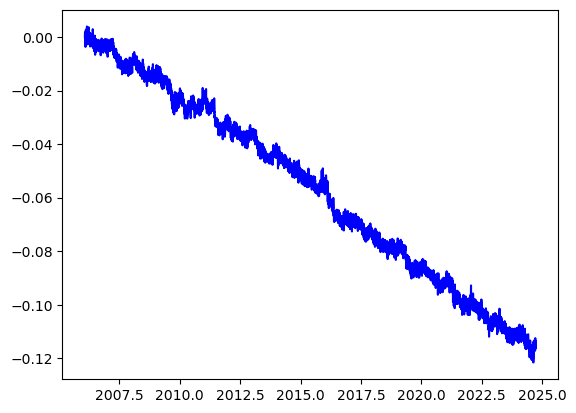

In [29]:
from sklearn.linear_model import LinearRegression
# convert the data into numpy arrays.
E = np.asarray(df['new delta e (m)']).reshape(-1, 1)# reshaping was necessary to be an argument of Linear regress
# E = np.asarray(df['east'][df['station']==sta]).reshape(-1, 1)# reshaping was necessary to be an argument of Linear regress
# make a new time array
t = np.asarray(df['decimal year']).reshape(-1, 1)
tt = np.linspace(np.min(t),np.max(t),1000)

# perform the linear regression. First we will use the entire available data
regr = LinearRegression()
# we will first perform the fit:
regr.fit(t,E)
# We will first predict the fit:
Epred=regr.predict(t) 

# The coefficients
print('Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])
# plot the data
plt.plot(t,E,'b',label='data')

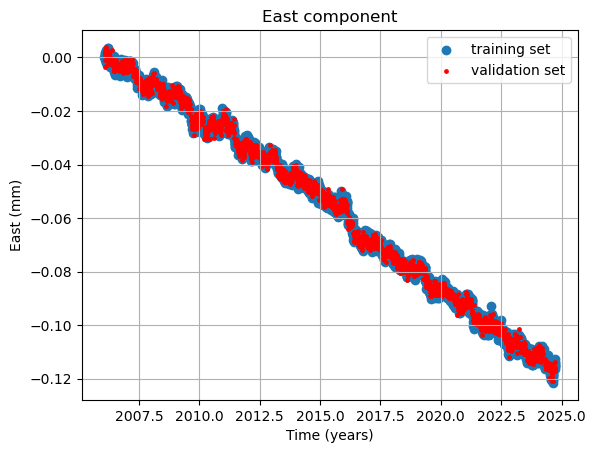

In [30]:
# we randomly select values and split the data between training and validation set.
from sklearn.model_selection import ShuffleSplit
# we split once the data between a training and a validating set 
n=1 # we do this selection once
v_size = 0.3 # 30% of the data will be randomly selected to be the validation set.

rs = ShuffleSplit(n_splits=n, test_size=.3, random_state=0)
for train_index, val_index in rs.split(E):
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
plt.scatter(t_train,E_train,marker="o");plt.grid(True);plt.ylabel('East (mm)')
plt.scatter(t_val,E_val,marker="o",s=6,c="red")
plt.xlabel('Time (years)')
plt.title('East component')
plt.legend(['training set','validation set'])

Training set: Coefficient / Velocity eastward (mm/year):  -0.006437910455226973
MSE (mean square error) on training set (mm): 0.00
Coefficient of determination on training set: 0.99
MSE on validation set (mm): 0.00 and coefficient of determiniation on 0.99


Text(0.5, 1.0, 'Random selection for data split')

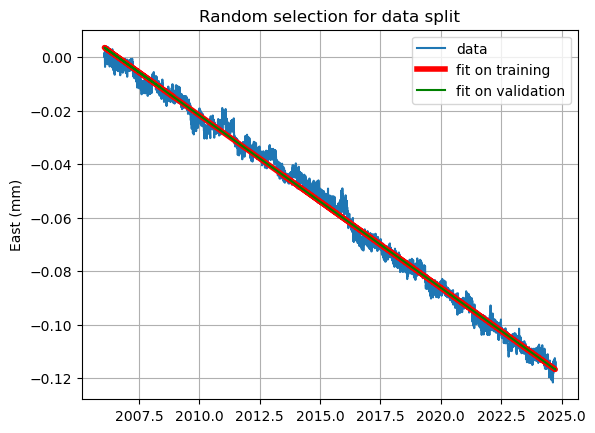

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# now fit the data on the training set.
regr = LinearRegression()
# Fit on training data:
regr.fit(t_train,E_train)
# We will first predict the fit:
Epred=regr.predict(t_train) 
Epred_val=regr.predict(t_val) 

# The coefficients
print('Training set: Coefficient / Velocity eastward (mm/year): ', regr.coef_[0][0])

print('MSE (mean square error) on training set (mm): %.2f'
      % mean_squared_error(Epred, E_train))
# The coefficient of determination: 1 is the perfect prediction
print('Coefficient of determination on training set: %.2f'
      % r2_score(Epred, E_train))

print('MSE on validation set (mm): %.2f and coefficient of determiniation on %.2f' %(mean_squared_error(Epred_val, E_val), r2_score(Epred_val, E_val)))


plt.plot(t,E);plt.grid(True);plt.ylabel('East (mm)')
plt.plot(t_train,Epred,color="red",linewidth=4)
plt.plot(t_val,Epred_val,color="green")
plt.legend(['data','fit on training','fit on validation'])
plt.title('Random selection for data split')


### 2.5 Leave One Out Cross Validation

LOOCV splits the data in 2 sets (training and validation) <i>n</i> times (<i>n</i> is the number of data points). At each repeat, the training set is **all but one** data, the validation set is one element.



![Validation Set Approach](../img/LOOCV.png)
Advantages: it has far less bias with respect to the training data. It does not overestimate the test error. Repeated LOOCV will give the exact same results.

Disadvantages: it is computationally intensive.

* **Data Splitting**: LOOCV is an extreme form of cross-validation where, for each iteration, only one data point is left out as the test set, and the remaining data is used as the training set. This process is repeated for each data point, effectively creating as many folds as there are data points.

* **Estimation**: LOOCV is primarily used for assessing model performance and estimating predictive accuracy. By evaluating the model against all data points one at a time, LOOCV provides a robust assessment of a model's ability to generalize to unseen data.

* **Correlated Data**: LOOCV, like other cross-validation methods, may not explicitly address correlated data. However, its performance can be influenced by the correlation structure in the data. For datasets with strong correlations, LOOCV may lead to models that are overly optimistic since it often tests a model on data points that are closely related to the training set.

* **Applications**: LOOCV is valuable for evaluating machine learning and statistical models, particularly when you have a limited amount of data.

In [8]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

vel = np.zeros(len(E)) # initalize a vector to store the regression values
mse_train = np.zeros(len(E))
mse_val = np.zeros(len(E))
r2s = np.zeros(len(E))
i=0
for train_index, test_index in loo.split(E):    
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(t_train,E_train)
    # We will first predict the fit:
    Epred_train=regr.predict(t_train) 
    Epred_val=regr.predict(t_val) 

    # The coefficients
    vel[i]= regr.coef_[0][0]
    mse_train[i]= mean_squared_error(E_train, Epred_train)
    mse_val[i]= mean_squared_error(E_val, Epred_val)
    r2s[i]=r2_score(E_val, Epred_val)
    i+=1

# the data shows clearly a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %f4.2 and the standard deviation %f4.2"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("CV = %4.2f"%(np.mean(mse_val)))

mean of the velocity estimates -0.0064404.2 and the standard deviation 0.0000004.2
CV = 0.00


LOOCV is rarely used in practice. This example is just to show the extreme end member of cross-fold validation.
### 2.6 K-fold cross validation

Designed to reduce the computational cost of LOOCV. Randomly devide over <i>k</i> groups/folds of approximately equal size. It is typical to use <i>5</i> or <i>10</i>.


![Validation Set Approach](../img/Kfold.png)

In [9]:
from sklearn.model_selection import KFold

# let's try on 10-folds, 10 adjacent split of the data.
k=10
kf = KFold(n_splits=k)

vel = np.zeros(k) # initalize a vector to store the regression values
mse_train = np.zeros(k)
mse_val = np.zeros(k)
r2s = np.zeros(k)
i=0
for train_index, val_index in kf.split(E):    
    E_train, E_val = E[train_index], E[val_index]
    t_train, t_val = t[train_index], t[val_index]
    # now fit the data on the training set.
    regr = LinearRegression()
    # Fit on training data:
    regr.fit(t_train,E_train)
    # We will first predict the fit:
    Epred_train=regr.predict(t_train) 
    Epred_val=regr.predict(t_val) 

    # The coefficients
    vel[i]= regr.coef_[0][0]
    mse_val[i]= mean_squared_error(E_val, Epred_val)
    mse_train[i]= mean_squared_error(E_train, Epred_train)
    r2s[i]=r2_score(E_train, Epred_train)
    i+=1

# the data shows clearly a trend, so the predictions of the trends are close to each other:
print("mean of the velocity estimates %4.2f and the standard deviation %4.2f"%(np.mean(vel),np.std(vel)))
# the test error is the average of the mean-square-errors
print("mean MSE for training set : %4.2f and the validation set: %4.2f"%(np.mean(mse_train),np.mean(mse_val)))

mean of the velocity estimates -0.01 and the standard deviation 0.00
mean MSE for training set : 0.00 and the validation set: 0.00




## 2. Hyper-parameter tuning

In classic machine learning, models often have parameters that are learned from the training data (such as weights in a linear regression model), and hyperparameters that are external configuration settings. Hyperparameters are not learned from the data but are set prior to the training process and can significantly impact the model's performance.

The goal of hyperparameter tuning is to find the optimal combination of hyperparameter values that maximizes the model's performance on a given dataset. This process helps fine-tune the model to achieve the best possible results and avoid overfitting or underfitting.

Hyper-parameter tuning is now ***standard*** and should be performed in every work.

Several approaches exists to hyper-parameter tuning:
* **Manual Tuning:** 
    * While more time-consuming, manual tuning involves domain experts iteratively adjusting hyperparameters based on their understanding of the problem and the model's behavior.
    * This approach can be effective when the hyperparameter space is relatively small or when there is substantial domain knowledge.
    * This is a good step for initial exploration and intuition-building experiment, but systematic approaches like described below will be required for robust assessment.
* **Grid Search:**
    * In this method, a predefined set of hyperparameter values is specified, and the model is trained and evaluated for all possible combinations.
    * While thorough, grid search can be computationally expensive, especially for a large number of hyperparameters or when the search space is extensive.
    * This method is implemented in the ```scikit-learn``` ecosystem as ```model_selection.GridSearchCV```, which uses cross-validation to train-test each model given the tested hyper-parameters.
* **Random Search:**
    * Random search involves randomly selecting combinations of hyperparameter values from a predefined distribution of hyperparameters (e.g., uniform or normal).
    * This approach is more computationally efficient than grid search, as it explores a diverse set of hyperparameter combinations.
    * The method is implement in the ```scikit-learn``` ecosystem as ```model_selection.RandomizedSearchCV```, which uses cross-validation for each  
* **Bayesian Optimization:**
    * Bayesian optimization employs probabilistic models to predict the performance of different hyperparameter configurations.
    * It adapts its search based on the results of previous evaluations, allowing it to focus on promising regions of the hyperparameter space.


    Below is a tutorial using the ```digits``` data sets.


In [31]:
# basic tools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [33]:
# dataseta
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [34]:
# explore data type
data,y = digits["data"].copy(),digits["target"].copy()
print(type(data[0][:]),type(y[0]))
# note that we do not modify the raw data that is stored on the digits dictionary.

<class 'numpy.ndarray'> <class 'numpy.int64'>


Plot the data

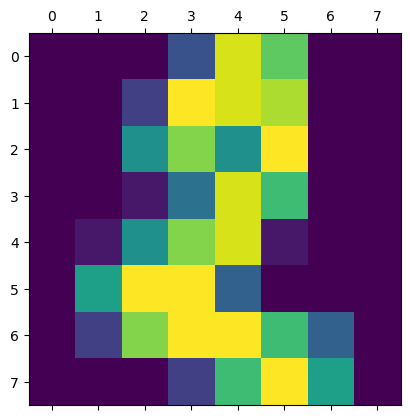

In [36]:
plt.matshow(digits["images"][2])

In [37]:
print(min(data[0]),max(data[0]))
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler()
scaler.fit_transform(data)# fit the model for data normalization
newdata = scaler.transform(data) # transform the data. watch that data was converted to a numpy array

# Split data into 80% train and 20% test subsets
print(f"There are {data.shape[0]} data samples")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, shuffle=False)


0.0 15.0
There are 1797 data samples


In [38]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

# Support Vector Machine classifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train) # learn
knn_prediction = clf.predict(X_test) # predict on test
print("SVC Accuracy:", metrics.accuracy_score(y_true=y_test ,y_pred=knn_prediction))


SVC Accuracy: 0.9666666666666667


what are the parameters we are trying to optimize?

In [39]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

A search consists of:

* an estimator (regressor or classifier such as ``KNN()``);

* a parameter space;

* a method for searching or sampling candidates (grid search or random selection);

* a cross-validation scheme; and

* a loss function or a scoring metrics.


## 1. Grid Search cross validation. 
Performs the search in the brute-force way using cross-validation. One has to define the parameter space. The scikit-learn function is ``GridSearchCV``. More details [here](!https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).



In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'n_neighbors': [1,2,3,4,5,6,7,8,9,10], 'weights': ['uniform','distance'], 'algorithm': [ 'ball_tree', 'kd_tree'],
   'metric':['euclidean','manhattan','chebyshev','minkowski']}
 ]

The algorithm will search for all combinations of parameters, which can be from the model algorithms or the choice of features.

In [41]:
search = GridSearchCV(clf, param_grid, cv=5,verbose=3)

In [42]:
search.fit(X_train, y_train) # learn

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV 1/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=1, weights=uniform;, score=0.948 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=1, weights=uniform;, score=0.983 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=1, weights=uniform;, score=0.983 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=1, weights=uniform;, score=0.965 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=1, weights=uniform;, score=0.986 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=1, weights=distance;, score=0.948 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=1, weights=distance;, score=0.983 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=euclidean, n_neighbors=1, weights=distance;, score=0.983 total time=   0.0s
[CV 4/

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree'],
                          'metric': ['euclidean', 'manhattan', 'chebyshev',
                                     'minkowski'],
                          'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [43]:
search.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 3,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsClassifier(n_neighbors=3),
 'n_jobs': None,
 'param_grid': [{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
   'weights': ['uniform', 'distance'],
   'algorithm': ['ball_tree', 'kd_tree'],
   'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 3}

In [47]:
search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_algorithm', 'param_metric', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [22]:
search.best_params_

{'algorithm': 'ball_tree',
 'metric': 'euclidean',
 'n_neighbors': 1,
 'weights': 'uniform'}

## 2. Random Search Cross Validation.
It performs the search in the brute-force way using cross-validation. One has to define the parameter space. The scikit-learn function is ``GridSearchCV``. More details [here](!https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

The advantage is that it can be used for a wide hyperparameter space and limit to ``n_iter`` number of iterations.

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import  randint


distributions= [ {'n_neighbors': randint.rvs(low=1,high=10,size=10), 'weights': ['uniform','distance'], 'algorithm': [ 'ball_tree', 'kd_tree'],
                  'metric':['euclidean','manhattan','chebyshev','minkowski']} ]
clf2 = RandomizedSearchCV(clf, distributions, random_state=0,cv=5,n_iter=100)
clf2.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
                   n_iter=100,
                   param_distributions=[{'algorithm': ['ball_tree', 'kd_tree'],
                                         'metric': ['euclidean', 'manhattan',
                                                    'chebyshev', 'minkowski'],
                                         'n_neighbors': array([9, 3, 5, 7, 8, 5, 6, 7, 7, 8]),
                                         'weights': ['uniform', 'distance']}],
                   random_state=0)

In [46]:
print(search.best_params_)
print(clf2.best_params_)

{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
{'weights': 'distance', 'n_neighbors': 3, 'metric': 'minkowski', 'algorithm': 'kd_tree'}
